In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import savemat
import math
from loading_real_wave_noise import loading_real_wave_noise
from Reading_path_test import loading_paths_from_MAT
from Control_filter_selection import Control_filter_selection
from Fixed_filter_noise_cancellation_subfilters import Fixed_filter_controller
from Disturbance_generation import Disturbance_generation_from_real_noise

print(torch.cuda.is_available())

True


In [2]:
# Loading real noises
mdict = {}
fs = 16000
StepSize = 0.0001
sound_name = 'Aircraft'
waveform, resample_rate = loading_real_wave_noise(folde_name='Real Noise Examples/', sound_name=sound_name+'.wav')

In [3]:
# Loading path
Pri_path, Secon_path = loading_paths_from_MAT(folder='Pz and Sz', subfolder='Dongyuan', Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')
Dis, Fx, Re = Disturbance_generation_from_real_noise(fs=fs, Repet=0, wave_form=waveform, Pri_path=Pri_path, Sec_path=Secon_path)
# Dis: disturbance (cotrolled noise)， Fx: fixed-x signal, Re: repeated waveform (primary_noise) Repetition=Repet+1

In [4]:
print(waveform.shape)
print(Dis.shape)
print(Fx.shape)
print(Re.shape)

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

torch.Size([1, 160000])
torch.Size([160000])
torch.Size([160000])
torch.Size([160000])


The primary nosie has 10 seconds !!!
1 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
2 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
3 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
4 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
5 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
6 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
7 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
8 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
9 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
10 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


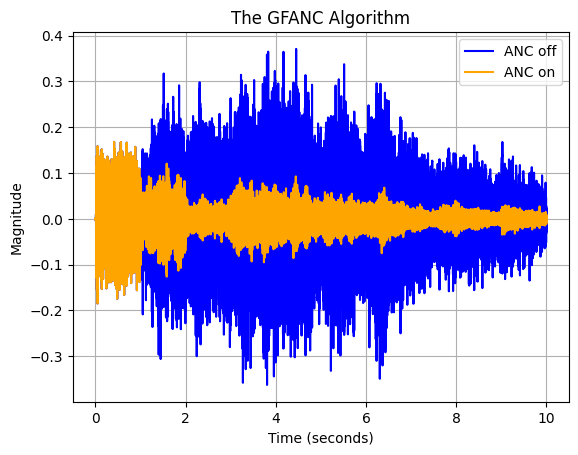

In [6]:
# GFANC: present frame to predict the next

MODEL_PTH = 'models/M6_res_Synthetic.pth'
path_mat = 'models/Pretrained_Sub_Control_filters.mat'

# prediction index
Filter_vector = Control_filter_selection(fs=16000, MODEL_PTH=MODEL_PTH, path_mat=path_mat, Primary_noise=Re.unsqueeze(0), threshold=0.5)

Fixed_Cancellation = Fixed_filter_controller(Filter_vector=Filter_vector, fs=16000)
ErrorFixed2 = Fixed_Cancellation.noise_cancellation(Dis=Dis, Fx=Fx)

Time = np.arange(len(Dis))*(1/fs)


plt.title('The GFANC Algorithm')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, ErrorFixed2, color='orange', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
#plt.savefig('GFANC2.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()